In [1]:
import pandas as pd
import nibabel as nib
import glob
import os
import numpy as np
import seaborn as sns
from scipy import spatial, stats
import matplotlib.pyplot as plt
from radiomics import featureextractor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay

In [2]:
def load_nib_file(path):
    mask = nib.load(path)
    mask_data = mask.get_fdata()

    return mask, mask_data


def extract_radiomics_features(list_train, path_data, errors, list_test=None, path_data_test=None):
    train_features = {}
    train_shape_features = {}
    if list_test is not None:
        list_to_parse = list_train + list_test
        test_features = {}
        test_shape_features = {}
    else:
        list_to_parse = list_train
    for case in list_to_parse:
        print(case)
        if case in list_train:
            path = path_data
        elif case in list_test:
            path = path_data_test

        image = glob.glob(path + case + '/T1_*_CR_2mm.nii.gz')
        mask = glob.glob(path + case + '/GT_RS_CR_2mm.nii.gz')

        try:
            features = featureextractor.RadiomicsFeatureExtractor()
            features.disableAllFeatures()
            features.enableFeatureClassByName('shape')
            results = features.execute(image[0], mask[0])
            features = {key[15:]: float(results[key]) for key in results.keys() if 'shape' in key}
            if case in list_train:
                train_features.update({case: results})
                train_shape_features.update({case: features})
            elif case in list_test:
                test_features.update({case: results})
                test_shape_features.update({case: features})
        except ValueError as e:
            errors.append(mask)
            result_to_print=re.search('ITK ERROR', format_exc())
            result_to_print_during=re.search('During handling', format_exc())
            print(format_exc()[result_to_print.span()[0]:result_to_print_during.span()[0]])
            
    if list_test is not None:
        return features.keys(), errors, train_features, train_shape_features, test_features, test_shape_features
    else:
        return errors, train_features, train_shape_features

In [3]:
# paths to train and test sets
path_data_baseline_ozgun = "/mnt/data/psteinmetz/neotex/data_MRI/2training_sets_forPCA/"
path_data_MP = "/mnt/data/psteinmetz/neotex/data_MRI/follow_up/Training/"
path_data_MP_test = "/mnt/data/psteinmetz/neotex/data_MRI/follow_up/Testing/"
path_data_baseline_test = "/mnt/data/psteinmetz/neotex/data_MRI/baseline_data/Testing/"
path_data_sheet_MP = "/mnt/data/psteinmetz/neotex/data_MRI/results_Training+Ozgun_test_BDD_25.ods"
path_data_sheet_Baseline = "/mnt/data/psteinmetz/neotex/data_MRI/results_Training+Ozgun+Miparcours_test_BDD_30_2.ods"

In [4]:
# measured perf of algo
scores_MP = pd.read_excel(path_data_sheet_MP, sheet_name="Sheet2", index_col='case')
scores_baseline = pd.read_excel(path_data_sheet_Baseline, sheet_name="Sheet2", index_col='case')

scores = pd.concat((scores_MP, scores_baseline))

# lists of cases
list_training_2sets = [x for x in os.listdir(path_data_baseline_ozgun) if '.' not in x]
list_training_MP = [x for x in os.listdir(path_data_MP) if '.' not in x]
list_testing_MP = [x for x in os.listdir(path_data_MP_test) if '.' not in x]
list_testing_baseline = [x for x in os.listdir(path_data_baseline_test) if '.' not in x]

errors = []

In [5]:
scores

,2trainsets,3trainsets
case,,
case_47_MP,0.000000,0.000000
case_48_MP,0.750654,0.817985
case_49_MP,0.012903,0.370514
case_50_MP,0.000000,0.421242
case_51_MP,0.820170,0.672198
case_52_MP,0.003886,0.641568
case_53_MP,0.839178,0.841722
case_54_MP,0.000000,0.000000
case_56_MP,0.725351,0.755827


In [6]:
# extraction of radiomic features
errors_2sets, train_features_2sets, train_shape_features_2sets = extract_radiomics_features(list_training_2sets, path_data_baseline_ozgun, errors)
errors_testing_baseline, baseline_test_features, baseline_test_shape_features = extract_radiomics_features(list_testing_baseline, path_data_baseline_test, errors)
features, errors_MP, train_features_MP, train_shape_features_MP, test_features, test_shape_features = extract_radiomics_features(list_training_MP, path_data_MP, errors, list_testing_MP, path_data_MP_test)

case_56_Ozgun
case_16_Ozgun
case_1_Ozgun
case_51
case_51_Ozgun
case_116
case_60_Ozgun
case_48_Ozgun
case_7_Ozgun
case_50_Ozgun
case_124
case_22_Ozgun
case_59
case_52
case_36_Ozgun
case_42_Ozgun
case_53
case_25_Ozgun
case_96
case_18_Ozgun
case_130
case_17_Ozgun
case_98
case_13
case_73
case_59_Ozgun
case_61_Ozgun
case_47_Ozgun
case_30
case_5
case_122
case_11_Ozgun
case_93
case_53_Ozgun
case_0
case_37
case_115
case_44
case_100
case_139
case_49_Ozgun
case_62_Ozgun
case_35_Ozgun
case_21
case_128
case_136
case_33
case_5_Ozgun
case_20_Ozgun
case_97
case_95
case_23_Ozgun
case_6
case_135
case_58_Ozgun
case_83
case_125
case_40_Ozgun
case_29_Ozgun
case_28
case_92
case_123
case_111
case_25
case_84
case_41_Ozgun
case_114
case_86
case_99
case_90
case_32_Ozgun
case_79
case_107
case_57_Ozgun
case_4_Ozgun
case_24_Ozgun
case_45
case_133
case_8_Ozgun
case_38
case_141
case_55_Ozgun
case_89
case_104
case_108
case_14_Ozgun
case_12_Ozgun
case_120
case_34_Ozgun
case_119
case_40
case_9_Ozgun
case_134
case_71
c

In [7]:
#define cases that had a dice > 0.7
scores['state'] = np.where(scores['3trainsets'] >= 0.7, 1, 0)
scores

,2trainsets,3trainsets,state
case,,,
case_47_MP,0.000000,0.000000,0
case_48_MP,0.750654,0.817985,1
case_49_MP,0.012903,0.370514,0
case_50_MP,0.000000,0.421242,0
case_51_MP,0.820170,0.672198,0
case_52_MP,0.003886,0.641568,0
case_53_MP,0.839178,0.841722,1
case_54_MP,0.000000,0.000000,0
case_56_MP,0.725351,0.755827,1


In [8]:
#start with tumor volume
volume_test = pd.concat((pd.DataFrame.from_dict(test_shape_features).T[['MeshVolume', 'SurfaceVolumeRatio']], pd.DataFrame.from_dict(baseline_test_shape_features).T[['MeshVolume', 'SurfaceVolumeRatio']]), axis=0)
volume_train = pd.concat((pd.DataFrame.from_dict(train_shape_features_MP).T[['MeshVolume', 'SurfaceVolumeRatio']], pd.DataFrame.from_dict(train_shape_features_2sets).T[['MeshVolume', 'SurfaceVolumeRatio']]), axis=0)
volumes_logis = pd.concat((scores['state'], volume_test), axis=1)

In [9]:
volume_train

,MeshVolume,SurfaceVolumeRatio
case_44_MP,1489.666667,0.490548
case_126_MP,2764.666667,0.478592
case_123_MP,9255.666667,0.312528
case_114_MP,142532.666667,0.152635
case_41_MP,53312.000000,0.220800
...,...,...
case_137,14506.666667,0.270125
case_36,66920.333333,0.281386
case_33_Ozgun,5696.000000,0.292614
case_57,6475.333333,0.359133


In [10]:
X, y = np.array(volumes_logis[['MeshVolume', 'SurfaceVolumeRatio']]), np.array(volumes_logis['state'])

In [11]:
X_train = X.reshape(-1, 1)
y_train = y.reshape(-1, 1)

In [12]:
 clf = LogisticRegression(random_state=0).fit(X, y)

In [13]:
clf.score(X, y)

0.8148148148148148

In [14]:
# Predict probabilities
y_prob = clf.predict_proba(X)[:, 1]
y_pred = clf.predict(X)

# Compute ROC curve
fpr, tpr, _ = roc_curve(y, y_prob)

In [15]:
y

array([0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 1])

In [16]:
np.unique(y, return_counts=True)

(array([0, 1]), array([25, 29]))

In [17]:
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 0])

In [18]:
roc_auc = roc_auc_score(y, y_prob)

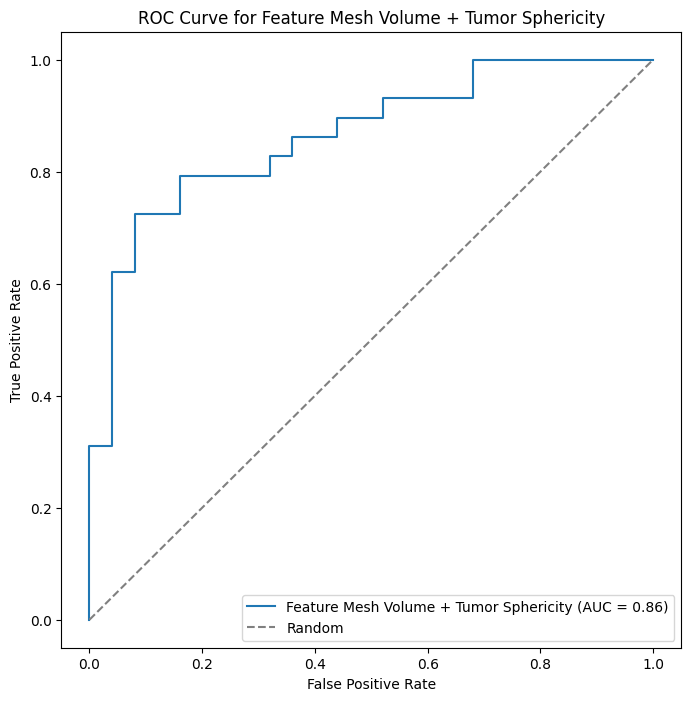

In [19]:
for feature_idx in ['Mesh Volume + Tumor Sphericity']:    
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, label=f'Feature {feature_idx} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for Feature {feature_idx}')
    plt.legend()
    plt.show()

In [20]:
cm = confusion_matrix(y_train, y_pred)

In [21]:
print(cm)

[[23  2]
 [ 8 21]]


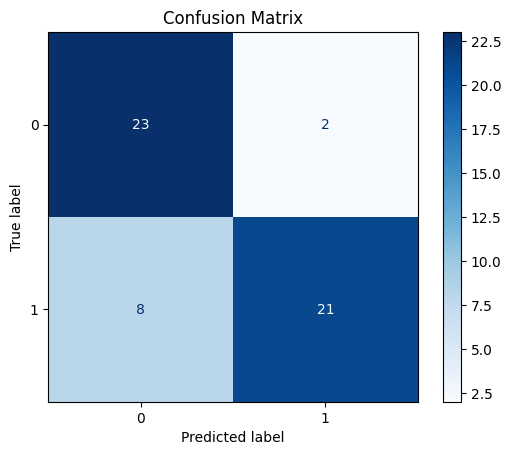

In [22]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(cmap='Blues', values_format='.4g')

plt.title('Confusion Matrix')
plt.show()

ValueError: x and y must be the same size

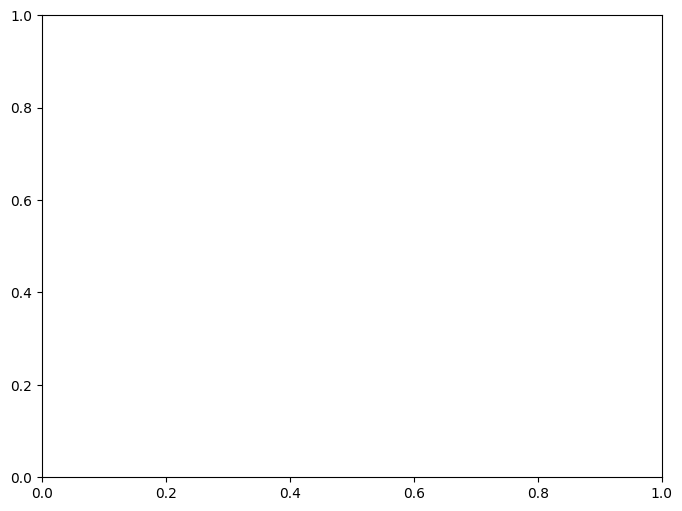

In [110]:
plt.figure(figsize=(8, 6))

# Plot training points
plt.scatter(X_train, y_train, c=y_train, cmap='viridis', marker='o', edgecolors='k', label='Training points')


x_values = np.linspace(X_train.min(), X_train.max(), 1000).reshape(-1, 1)
y_probs = clf.predict_proba(x_values)[:, 1]

plt.plot(x_values, y_probs, color='red', label='Logistic Regression Decision Boundary')
# Add labels and legend
plt.xlabel('Surface Volume Ratio')
plt.ylabel('Probability Dice >=0.7')
plt.title('Logistic Regression Decision Boundary')
#plt.legend()
plt.show()

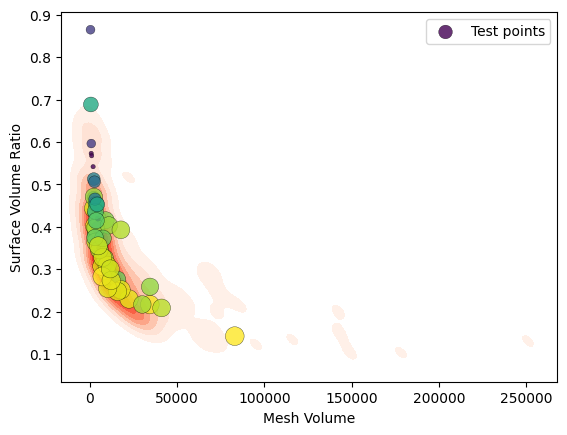

In [23]:
sns.kdeplot(x=volume_train['MeshVolume'], y=volume_train['SurfaceVolumeRatio'], cmap='Reds', fill=True, bw_adjust=.5)

# Plot training points
sns.scatterplot(data=volumes_logis, x='MeshVolume', y='SurfaceVolumeRatio', c=scores['3trainsets'], cmap='viridis', s=(scores['3trainsets']+0.05)*200, marker='o', edgecolors='k', label='Test points', alpha=.8, legend="full", hue_norm=(0, 7))
#sns.scatterplot(data=volume_train, x='MeshVolume', y='SurfaceVolumeRatio', marker = 'x', alpha=.2)

# Add labels and legend
plt.xlabel('Mesh Volume')
#plt.xlim(0, 10000)
plt.ylabel('Surface Volume Ratio')
#plt.title('Logistic Regression Decision Boundary')
#plt.legend()
plt.show()

/tmp/ipykernel_2778548/707641534.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=volume_train['MeshVolume'], y=volume_train['SurfaceVolumeRatio'], cmap="Reds", shade=True, bw_adjust=.5)
/tmp/ipykernel_2778548/707641534.py:8: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax=sns.scatterplot(data=volumes_logis, x='MeshVolume', y='SurfaceVolumeRatio', c=scores['3trainsets'], palette='viridis', marker='o', edgecolors='k', label='Test points', alpha=.8)


ValueError: 'c' argument has 54 elements, which is inconsistent with 'x' and 'y' with size 486.

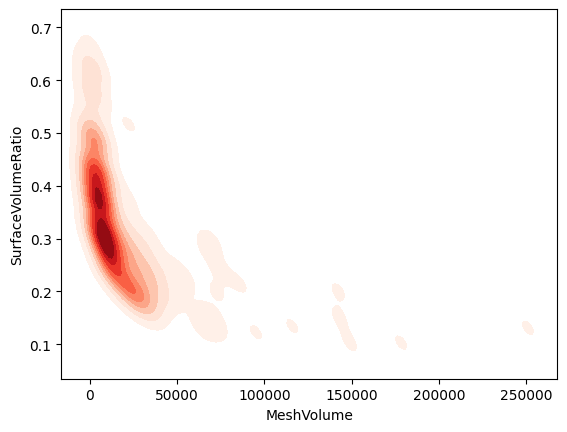

In [113]:
norm = plt.Normalize(scores['3trainsets'].min(), scores['3trainsets'].max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])

sns.kdeplot(x=volume_train['MeshVolume'], y=volume_train['SurfaceVolumeRatio'], cmap="Reds", shade=True, bw_adjust=.5)

# Plot training points
ax=sns.scatterplot(data=volumes_logis, x='MeshVolume', y='SurfaceVolumeRatio', c=scores['3trainsets'], palette='viridis', s=(scores['3trainsets']+0.05)*200, marker='o', edgecolors='k', label='Test points', alpha=.8)
#sns.scatterplot(data=volume_train, x='MeshVolume', y='SurfaceVolumeRatio', marker = 'x', alpha=.2)
ax.figure.colorbar(sm)

# Add labels and legend
plt.xlabel('Mesh Volume')
plt.ylabel('Surface Volume Ratio')
#plt.title('Logistic Regression Decision Boundary')
#plt.legend()
plt.show()

In [68]:
kernel3sets = stats.gaussian_kde(volume_train.T)
kde3sets = kernel3sets(volume_train.T)

In [71]:
results_3_sets=pd.DataFrame(kernel3sets.evaluate(volumes_logis[['MeshVolume', 'SurfaceVolumeRatio']].T), index=volumes_logis.index)

In [72]:
results_3_sets

,0
case_47_MP,7.874392e-05
case_48_MP,6.727974e-05
case_49_MP,5.182331e-05
case_50_MP,7.327867e-05
case_51_MP,9.627789e-05
case_52_MP,1.065330e-04
case_53_MP,8.935373e-05
case_54_MP,9.207728e-05
case_56_MP,9.207972e-05
case_57_MP,1.108585e-04


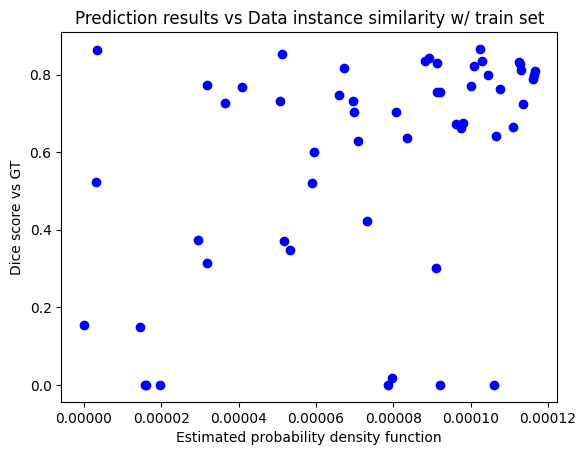

In [74]:
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(results_3_sets, scores['3trainsets'], c='b', marker='o')
#ax.set_xlim(0, 0.02)
ax.set_xlabel('Estimated probability density function')
ax.set_ylabel('Dice score vs GT')
ax.set_title('Prediction results vs Data instance similarity w/ train set')
plt.show()

In [49]:
X_train

array([[ 2909.        ],
       [ 2210.33333333],
       [ 2261.66666667],
       [ 2779.        ],
       [ 3341.33333333],
       [ 5424.66666667],
       [ 2906.66666667],
       [ 3379.66666667],
       [ 3658.        ],
       [15883.33333333],
       [ 9840.33333333],
       [ 4682.33333333],
       [ 9154.        ],
       [ 7006.33333333],
       [ 4426.        ],
       [ 2346.33333333],
       [ 1969.33333333],
       [  889.        ],
       [ 3240.33333333],
       [ 2773.66666667],
       [ 1138.66666667],
       [  678.33333333],
       [ 2390.66666667],
       [  917.66666667],
       [ 3700.66666667],
       [ 4684.33333333],
       [ 3301.33333333],
       [ 3405.        ],
       [10993.66666667],
       [ 8665.66666667],
       [34425.66666667],
       [22511.33333333],
       [83032.66666667],
       [30135.33333333],
       [ 9990.66666667],
       [17917.33333333],
       [41178.66666667],
       [ 5245.33333333],
       [15993.66666667],
       [ 5552.66666667],
